<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.c.autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard



# The following is to be able to mount Google Drive
from google.colab import drive

import os
import datetime
import shutil



# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


# To show time at each cell
# Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
!pip install ipython-autotime 
%load_ext autotime

--2020-04-07 17:55:08--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   3.12K  --.-KB/s    in 0s      

2020-04-07 17:55:08 (62.9 MB/s) - ‘andrea_models.py’ saved [3190/3190]

--2020-04-07 17:55:10--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request s

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=773f61622b40faaf0d6f962627de39dfcafb6324e9d7466d2c6ba570f19641ae
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


### Mount google drive

In [4]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/06.clustering-and-anomaly/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
time: 19.1 s


### Preprocessing

The following code is the same as in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb).

In [5]:
np.random.seed(9)
random.seed(9)
tf.random.set_seed(4)

! wget https://datahub.io/machine-learning/creditcard/r/creditcard.csv

df = pd.read_csv('creditcard.csv')
df.head()

df.info(verbose=True)
df['Class'].value_counts()
num_of_normal = sum( df['Class']=="'0'" )
num_of_anomalies = sum( df['Class']=="'1'" )
num_of_anomalies/num_of_normal

df = df.drop('Time', axis=1)
X = df.drop('Class', axis=1)
y = [1 if c=="'1'" else 0 for c in df['Class']] 

--2020-04-07 17:56:13--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 104.18.48.253, 104.18.49.253, 2606:4700:3033::6812:31fd, ...
Connecting to datahub.io (datahub.io)|104.18.48.253|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2020-04-07 17:56:15--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.18.48.253, 104.18.49.253, 2606:4700:3031::6812:30fd, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.18.48.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>] 144.11M  31.0MB/s    in 5

As always, we should always ahuffle the dataset

In [6]:
X, y = shuffle(X, y)

time: 115 ms


To select the best configuration, we will use the ground truth and compute the precision-recall curves and the ROC curve.

To avoid **data leakage**, we perform model selection on the training set only

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


time: 128 ms


We also scale the dataset.

In [8]:
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)

time: 78 ms


# Autoencoder build and training

Let's write the functions to build and train the model, similar to what we did in our [Neural Network's notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/04.neural_networks/neural_networks.ipynb).

In [9]:
n_features = X_tr_scaled.shape[1]
print("The number of features is ", n_features)


The number of features is  29
time: 1.27 ms


In [8]:
act_fun = 'tanh'

def build_model():

  model = Sequential([
      Dense(10, input_dim = n_features, activation=act_fun), # Encoder
      Dense(5, activation=act_fun), ### Latent representation
      Dense(10, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 5.09 ms


In [13]:
def train_model(nn_file, X_tr, y_tr, epochs, overwrite=False):
  """
  nn_file:  Before training, the model contained in this file will be loaded
            After training, the resulting model will be written in this file

  
  overwrite: If true, the model will be built and trained from scratch
  """

  ###################################
  #### CALLBACKS ####################
  ###################################
  plot_cb = PlotLossesKerasTF() # Plots the loss during training
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history


  if overwrite==True:
    os.remove(nn_file)
    os.remove(nn_file+'.csv')

  if not os.path.isfile(nn_file):
    model = build_model()
  else:
    model = load_model(nn_file)

  history = model.fit(X_tr, y_tr, epochs=epochs,
                      callbacks=[plot_cb, checkpoint_cb, logger_cb],
                      validation_split=0.2)
  
  return model

time: 7.11 ms


Let's now build and train our first autoencoder. Note that the X and Y are the same, since we want to train the NN to be able to reconstruct the input.

In the tensor board, select "Scalars"

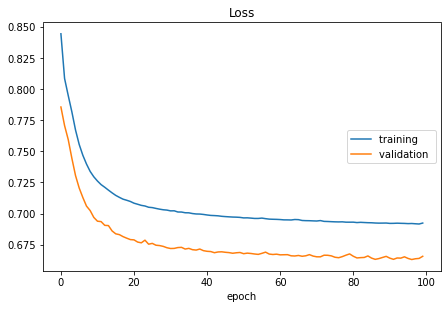

Loss
	training         	 (min:    0.692, max:    0.844, cur:    0.692)
	validation       	 (min:    0.663, max:    0.786, cur:    0.666)
3561/3561 [==============================] - 8s 2ms/step - loss: 0.6924 - val_loss: 0.6657
time: 13min 40s


In [10]:
nn_file = my_path + 'nn1.h5'

model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)



The loss remains too high

==> Clear sign of underfitting

==> We expect bad precision-recall and ROC curves

# First inspection to the Precision-Recall curve and the ROC curve

The **anomaly score** of each sample is the reconstruction error.

In [11]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

time: 2.9 s


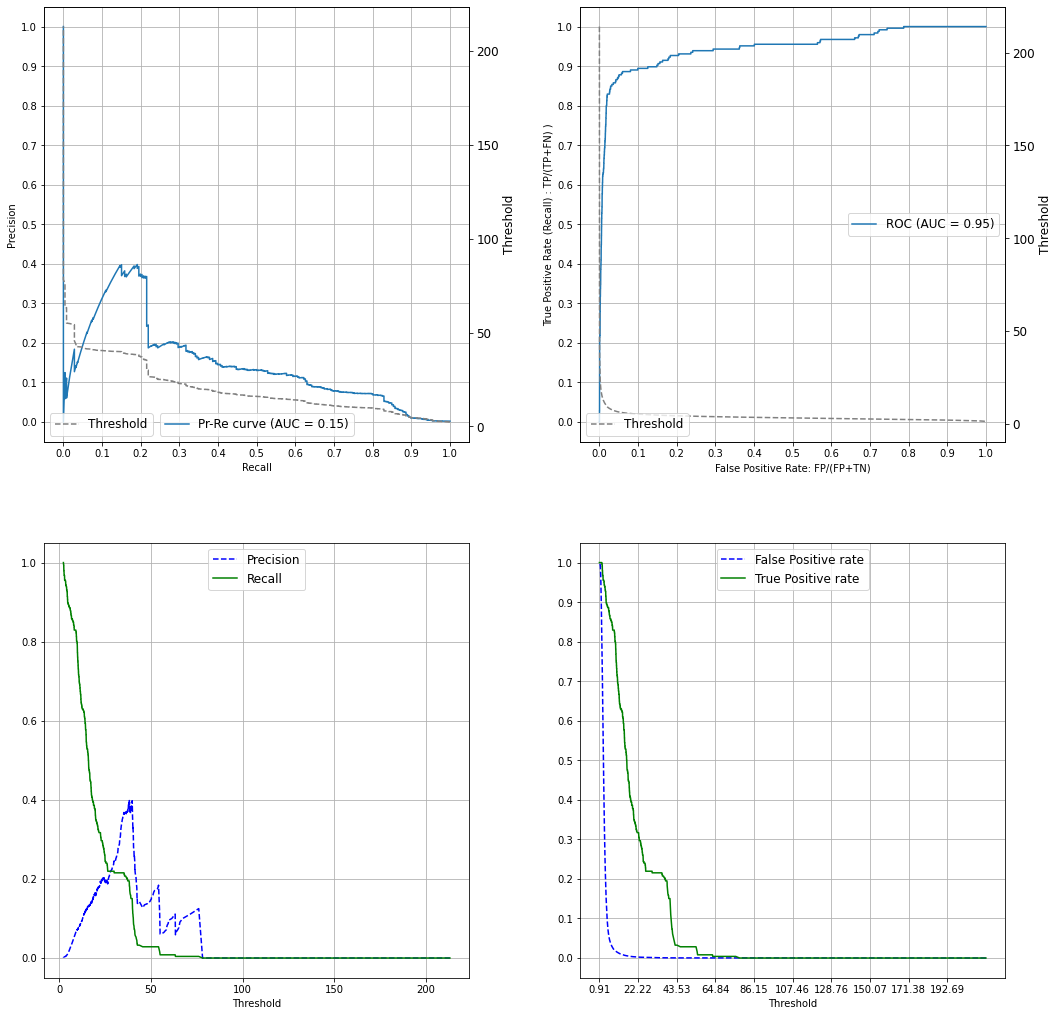

time: 1.23 s


In [12]:
evaluate_anomaly_detector(y_train, anomaly_scores)

# Solve the underfitting: Enlarge encoding layer

We may be compressing information too much. We need to allow the model to better adapt to the input data, by increasing the encoding layer

In [13]:
def build_model():

  model = Sequential([
      Dense(20, input_dim = n_features, activation=act_fun), # Encoder
      Dense(10, activation=act_fun), ### Latent representation
      Dense(20, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 4.03 ms


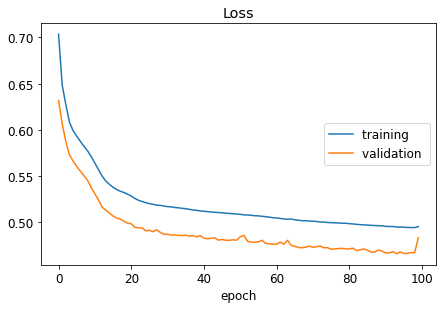

Loss
	training         	 (min:    0.494, max:    0.844, cur:    0.495)
	validation       	 (min:    0.465, max:    0.786, cur:    0.483)
3561/3561 [==============================] - 8s 2ms/step - loss: 0.4948 - val_loss: 0.4827
time: 13min 40s


In [16]:
nn_file = my_path + 'nn2.h5'

model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)


We reduced the loss, but it is still high

In [17]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

time: 2.89 s


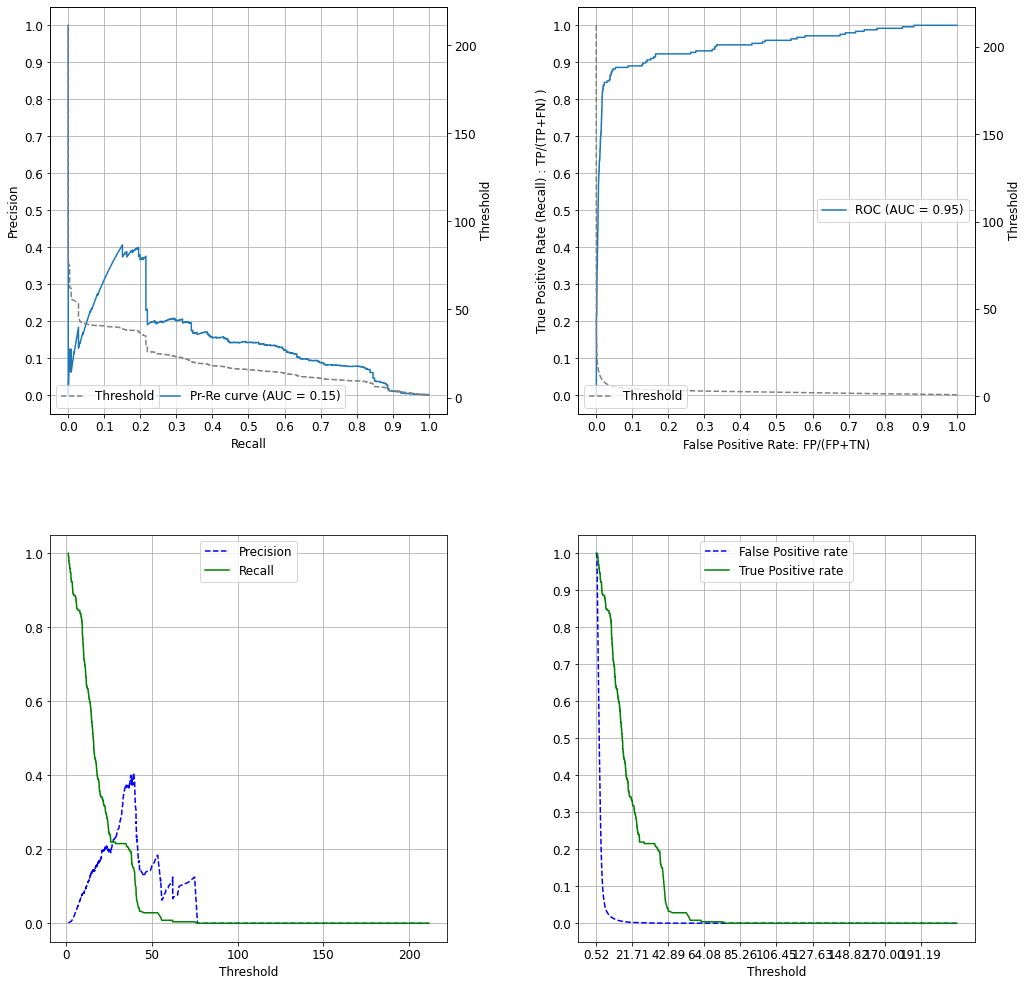

time: 1.27 s


In [18]:
evaluate_anomaly_detector(y_train, anomaly_scores)

# Solve underfitting: Deeper autoencoder

To solve underfitting, we need to make the model more flexible, i.e., more complex. We have tried to increase the encoding layer. Now, we try also to increase the depth, i.e., the numbr of layers.

In [19]:
def build_model():

  model = Sequential([
      Dense(20, input_dim = n_features, activation=act_fun), # Encoder
      Dense(15, activation=act_fun), # Encoder
      Dense(10, activation=act_fun), ### Latent representation
      Dense(15, activation=act_fun), # Decoder
      Dense(20, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 6.78 ms


Google interrupted my run and raised an error. Fortunately, the callbacks saved the status of the NN at every epoch.

The easiest way to recover the NN trained before the error is to add few training epochs.

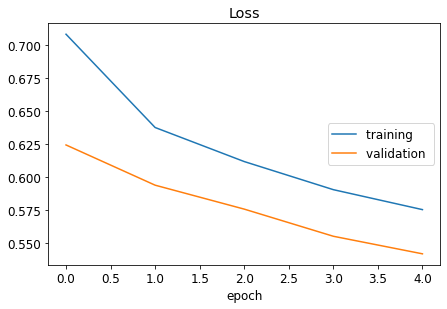

Loss
	training         	 (min:    0.494, max:    0.844, cur:    0.575)
	validation       	 (min:    0.465, max:    0.786, cur:    0.541)
3561/3561 [==============================] - 9s 2ms/step - loss: 0.5751 - val_loss: 0.5415
time: 44.6 s


In [20]:
nn_file = my_path + 'nn3.h5'

model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=5)


Let's plot the entire training history

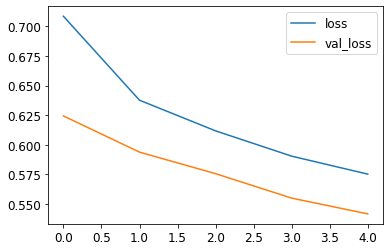

time: 172 ms


In [21]:
def plot_train_hist(csv_hist_file):
  hist_df = pd.read_csv(csv_hist_file)
  hist_df[['loss', 'val_loss']].plot()

plot_train_hist(nn_file+'.csv')

We reduced the loss, but not that much.

# Even larger encoding layer

In [22]:
def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoder
      Dense(24, activation=act_fun), # Encoder
      Dense(20, activation=act_fun), ### Latent representation
      Dense(24, activation=act_fun), # Decoder
      Dense(27, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 5.56 ms


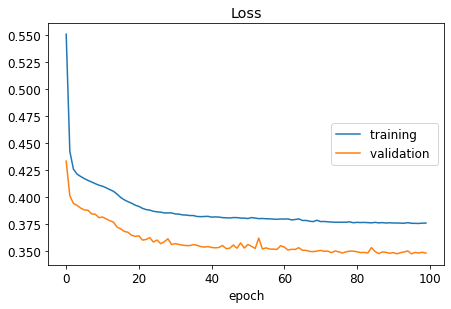

Loss
	training         	 (min:    0.376, max:    0.844, cur:    0.376)
	validation       	 (min:    0.347, max:    0.786, cur:    0.348)
3561/3561 [==============================] - 9s 2ms/step - loss: 0.3759 - val_loss: 0.3481
time: 14min 46s


In [23]:
nn_file = my_path + 'nn4.h5'

model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)

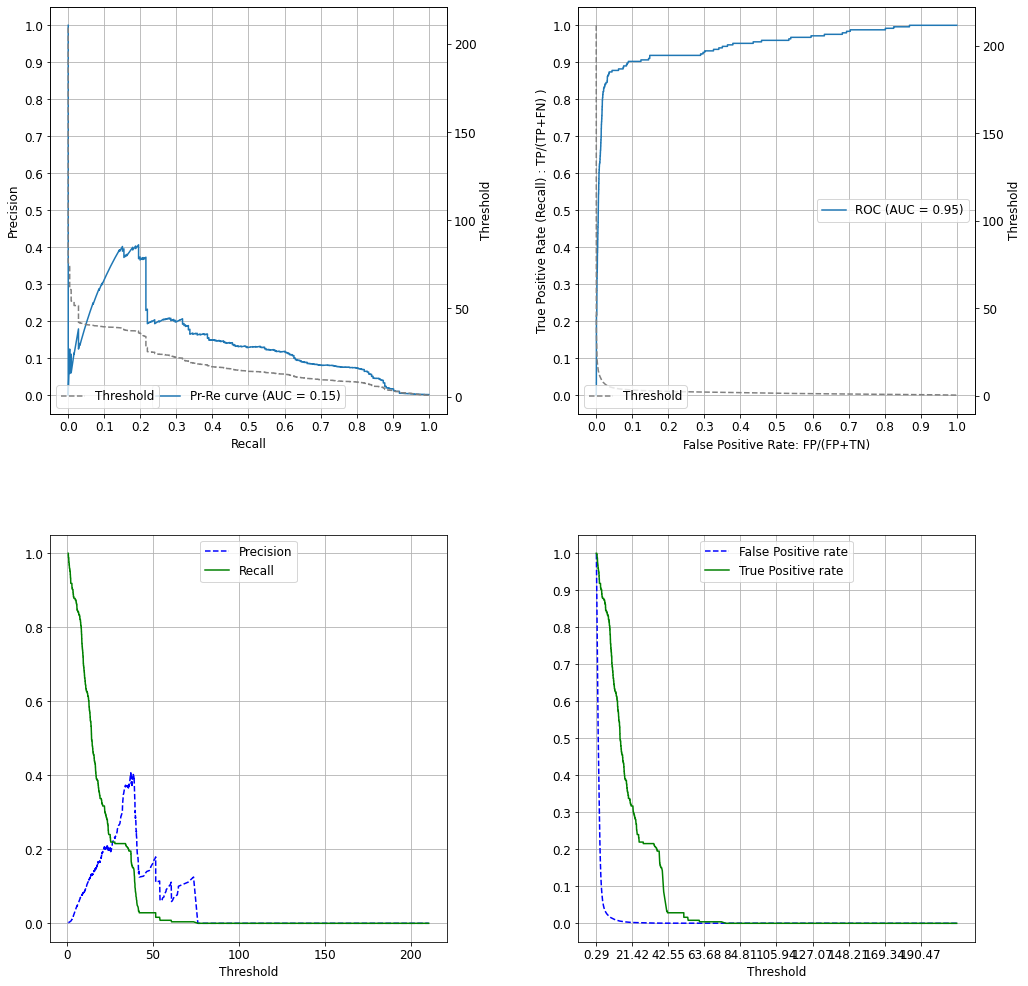

time: 4.2 s


In [24]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

evaluate_anomaly_detector(y_train, anomaly_scores)

# 23-neurons encoding layer

We observe that the training loss is still high and the curves could be improved. Let's try to give more flexibility to the middle layer

In [25]:
def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoder
      Dense(25, activation=act_fun), # Encoder
      Dense(23, activation=act_fun), ### Latent representation
      Dense(25, activation=act_fun), # Decoder
      Dense(27, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 5 ms


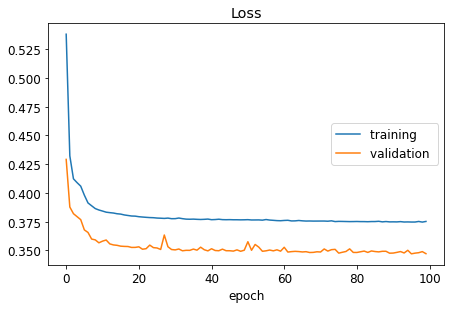

Loss
	training         	 (min:    0.375, max:    0.844, cur:    0.375)
	validation       	 (min:    0.347, max:    0.786, cur:    0.347)
3561/3561 [==============================] - 8s 2ms/step - loss: 0.3752 - val_loss: 0.3472
time: 14min 15s


In [26]:
nn_file = my_path + 'nn5.h5'

model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)

We did not improve a lot

# Shallow autoencoder with large encoding layer

In [27]:
act_fun = 'tanh'

def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoding layer
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 2.48 ms


In [28]:
nn_file = my_path + 'nn8.h5'

time: 1.51 ms


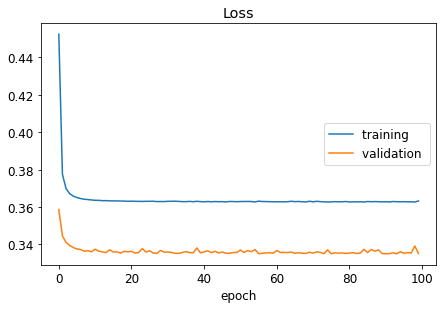

Loss
	training         	 (min:    0.363, max:    0.844, cur:    0.363)
	validation       	 (min:    0.335, max:    0.786, cur:    0.335)
3561/3561 [==============================] - 7s 2ms/step - loss: 0.3632 - val_loss: 0.3352
time: 12min 8s


In [29]:


model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)

### Changing activation function

In [30]:
act_fun = 'linear'

def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoding layer
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 3.69 ms


In [31]:
nn_file = my_path + 'nn9.h5'

time: 3.43 ms


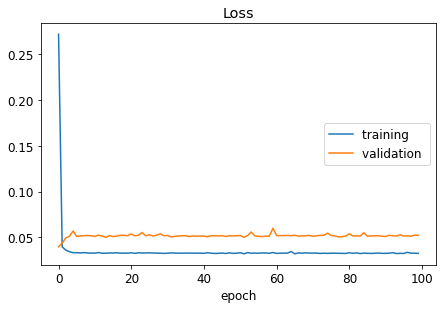

Loss
	training         	 (min:    0.032, max:    0.844, cur:    0.032)
	validation       	 (min:    0.040, max:    0.786, cur:    0.052)
3561/3561 [==============================] - 7s 2ms/step - loss: 0.0324 - val_loss: 0.0521
time: 12min


In [32]:
model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)

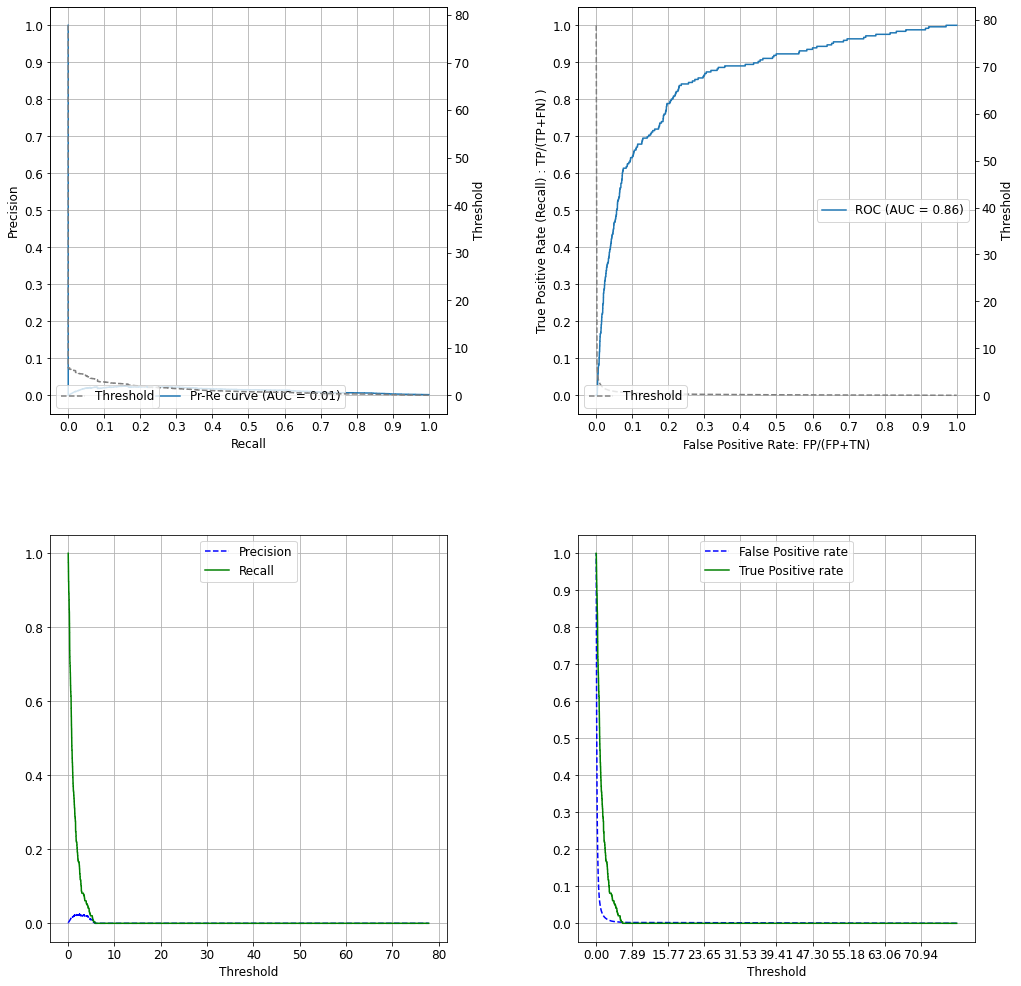

time: 3.51 s


In [33]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

evaluate_anomaly_detector(y_train, anomaly_scores)

This is an example of overfitting: the loss is "too good": the model is able to learn to reproduce the anomalies.

# Absolute error

In [15]:
act_fun = 'tanh'

def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoder
      Dense(25, activation=act_fun), # Encoder
      Dense(23, activation=act_fun), ### Latent representation
      Dense(25, activation=act_fun), # Decoder
      Dense(27, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

  return model

time: 6.33 ms


In [16]:
nn_file = my_path + 'nn10.h5'

time: 666 µs


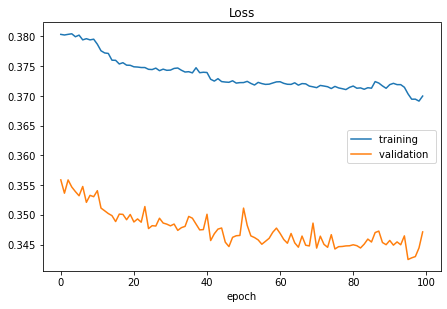

Loss
	training         	 (min:    0.369, max:    0.533, cur:    0.370)
	validation       	 (min:    0.342, max:    0.424, cur:    0.347)
3561/3561 [==============================] - 11s 3ms/step - loss: 0.3700 - val_loss: 0.3471
time: 17min 35s


In [17]:
model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)

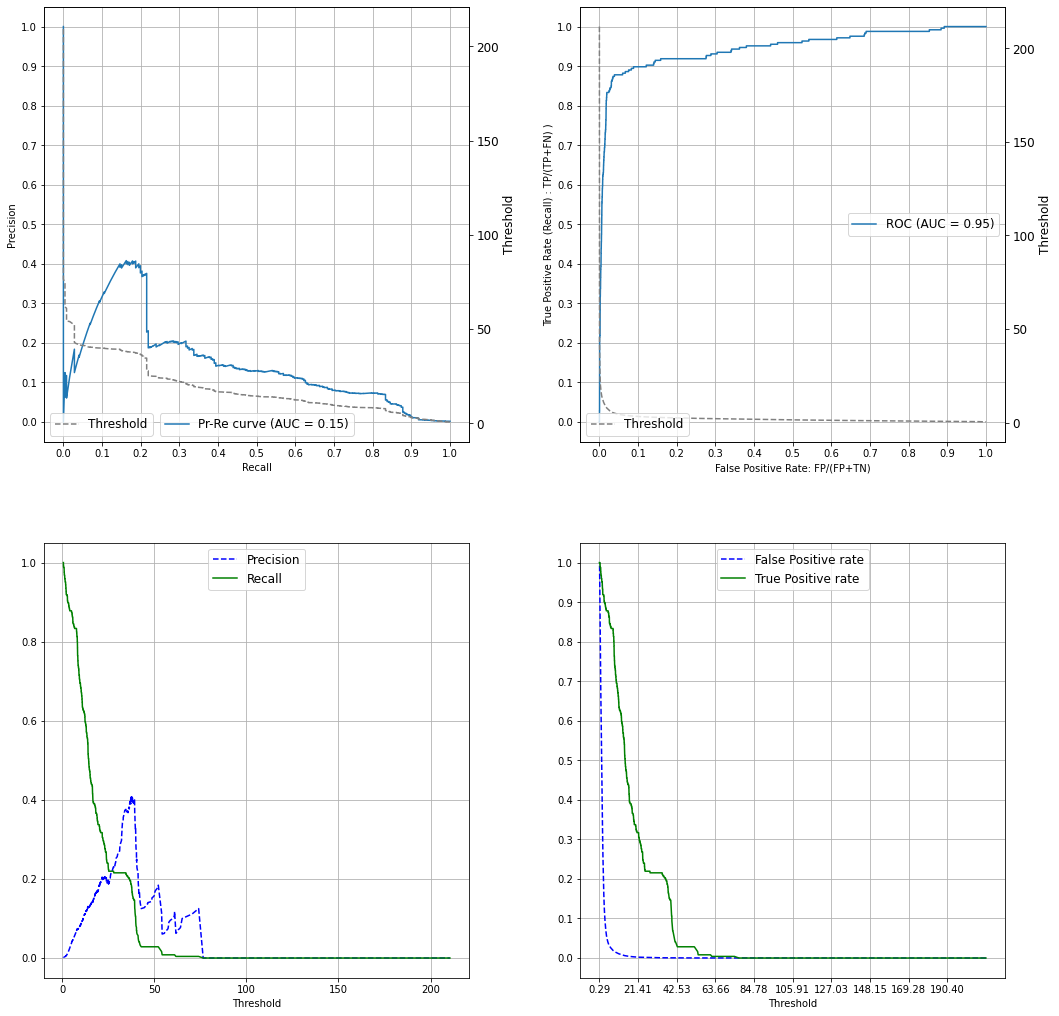

time: 4.76 s


In [18]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

evaluate_anomaly_detector(y_train, anomaly_scores)

# Other examples of Autoencoders for anomaly detection

* Application of autoencoders to the same dataset: Ch.8 of A. Patel, Hands-on unsupervised learning using Python, O'Reilly, 2019
* [Handwritten digits](https://visualstudiomagazine.com/articles/2019/03/01/neural-anomaly-detection-using-keras.aspx)